# Strain analysis

Copyright 2021 Marco A. Lopez-Sanchez.  
Content under [Creative Commons Attribution license CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/), code under [Mozilla Public License 2.0](https://www.mozilla.org/en-US/MPL/2.0/).

> **Goal**: Visualize and analise the evolution of strain using digital image correlation **Not yet finished!**

In [1]:
# Import neccesary libraries
import os
import numpy as np
import pandas as pd
from types import SimpleNamespace

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

## Load/import DIC data

The first step is to load the data as explained in the notebook [Loading data from DICe output](https://nbviewer.jupyter.org/github/marcoalopez/Jupyter4DICe/blob/f277d346a009570cf645123dc8fa93f7a0eea4f4/notebooks/LoadingDICe_data.ipynb). The main parameters of interest here are:

- In plane rotation (or rotation parallel to z axis)
- Virtual strain gauge (XX, YY, shear XY)

the region of interest considered looks as follows with grain boundaries outlined in yellow above the speckle random pattern for reference

![](figs/ROI_sample4_lowres.jpg)

The example dataset consist of a sequence of 10 time steps. The correlation was performed incrementally so that the deformation estimated by DICe represents incremental not cumulative deformations. The first five and the last five time steps represent different moments in the development of the deformation experiment (a link to the full paper will be provided soon!). In this example all DIC solutions are considered as correct and no data cleaning will be carried out, for this see the notebook "how to assess and visualise the quality of the DIC solution and clean the dataset".

> **DICe coordinate system**: Image coordinates in DICe are measured from the top left corner of the image with x positive to the right and y positive downward. Rotations are positive clockwise (opposite of the right-hand rule).

In [2]:
path = 'dataset/'

# loop to extract the data
count = 1
print('Stacking data...')

for filename in os.listdir(path):
    if filename.startswith('DICe') and filename.endswith('.txt'):
        
        # load the corresponding csv file
        df = pd.read_csv(path + filename, delimiter=',')
        
        # separate the different parameters of interest and reorganize them as a matrix
        rot_Z = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='ROTATION_Z')
        strainXX = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='VSG_STRAIN_XX')
        strainYY = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='VSG_STRAIN_YY')
        strainXY= df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='VSG_STRAIN_XY')
        
        # generate the numpy arrays
        if count == 1:
            rotZ_stack = np.array(rot_Z)
            strainXX_stack = np.array(strainXX)
            strainYY_stack = np.array(strainYY)
            strainXY_stack = np.array(strainXY)
            print(f'first processing file: {filename}')
            print('it might take a while...') 

        else:
            rotZ_stack = np.dstack((rotZ_stack, np.array(rot_Z)))
            strainXX_stack = np.dstack((strainXX_stack, np.array(strainXX)))
            strainYY_stack = np.dstack((strainYY_stack, np.array(strainYY)))
            strainXY_stack = np.dstack((strainXY_stack, np.array(strainXY)))
        count += 1
        print('#', end = '')

print('')
print(f'last processing file: {filename}')
print('Done!')
print(f'Shape of arrays: {strainXX_stack.shape}')

# Store all the Numpy arrays within the variable "data" using SimpleNamespace
data = SimpleNamespace(rotZ=rotZ_stack,
                       strainX=strainXX_stack,
                       strainY=strainYY_stack,
                       strainXY=strainXY_stack)

# remove variables that are not going to be used (to release RAM memory)
del df, count, filename, rot_Z, strainXX, strainYY, strainXY, rotZ_stack, strainXX_stack, strainYY_stack, strainXY_stack

Stacking data...
first processing file: DICe_solution_000.txt
it might take a while...
##########
last processing file: DICe_solution_074.txt
Done!
Shape of arrays: (377, 189, 10)


## Generate a Numpy array with the Von Mises 2D equivalent strain

To present the evolution of strain heterogeneities it is convenient to visualize the local strain by combining different components of the strain (XX, YY, XY) of the observed surface. For this we use the Von Mises 2D equivalent strain $\varepsilon_{eq}$ that can be estimated from the VSG strains using

$$
\varepsilon_{eq} = \sqrt{\frac{2}{3} \left( \varepsilon_{xx}^2 + \varepsilon_{yy}^2 + 2\varepsilon_{xy}^2 \right) }
$$

Let's create a Python function for this and then estimate the equivalent strain and store it within the ``data`` namespace with the field ``eq_strain``.

In [3]:
def VM_eq_strain(strain_xx, strain_yy, strain_xy):
    """ Estimate and plot the Von Mises 2D equivalent strain.

    Parameters
    ----------
    strain_xx : 2-dim numpy array
        The xx Green-Lagrange (VSG) strain component
    strain_yy : 2-dim numpy array
        The yy Green-Lagrange (VSG) strain component
    strain_xy : 2-dim numpy array
        The xy (shear) Green-Lagrange (VSG) strain component
    """

    return np.sqrt((2 / 3) * (strain_xx**2 + strain_yy**2 + 2 * strain_xy**2))

# vectorize the function for easy use with numpy arrays
vect_eq_strain = np.vectorize(VM_eq_strain)

In [4]:
# create the array with the equivalent strain and store it within the "data" object
data.eq_strain = vect_eq_strain(data.strainX, data.strainY, data.strainXY)

print("Shape of the 'eq_strain' array:", data.eq_strain.shape)

Shape of the 'eq_strain' array: (377, 189, 10)


For testing purposes, let's plot the equivalent strain for the first time steps

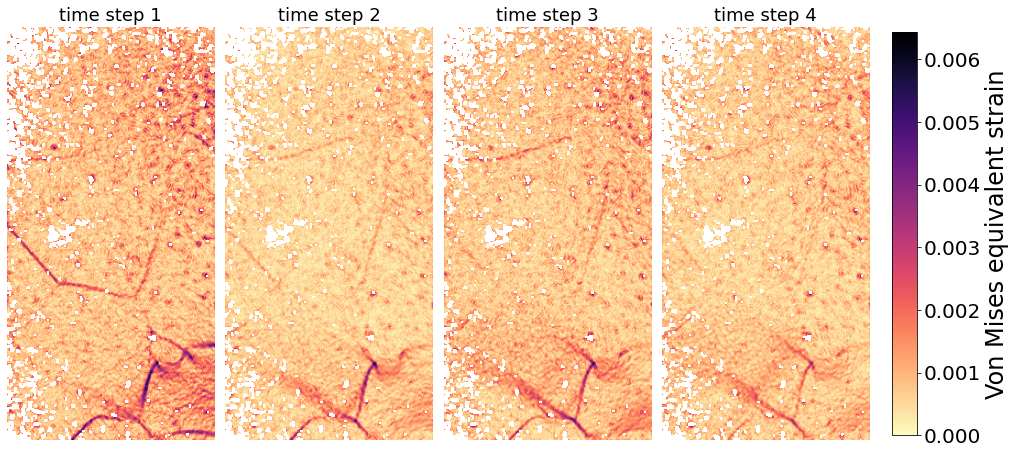

In [5]:
# initialize a figure with four axes (specifically 4 columns)
fig1, axes = plt.subplots(ncols=4, sharey=True, figsize=(14, 8), constrained_layout=True)

# loop through the axes to plot the different time steps
for index, ax in enumerate(axes.flat):
    ax.set_axis_off()
    im = ax.imshow(data.eq_strain[:, :, index], cmap='magma_r')
    ax.set_title(f'time step {index + 1}', fontsize=18)

# add color bar
cbar = fig1.colorbar(im, ax=axes, shrink=0.7, location='right')
cbar.set_label('Von Mises equivalent strain', fontsize=24)
cbar.ax.tick_params(labelsize=20)

Also, for comparison let's make a plot comparing the virtual strain gauges (VSG) XX, YY, XY estimated bu DICe and the equivalent stress for the time step 1 (index 0)

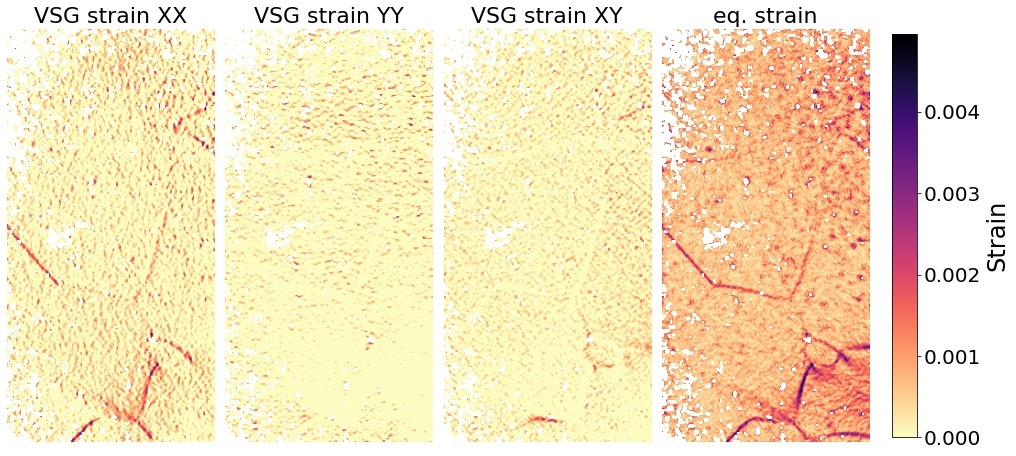

In [6]:
to_plot = (data.strainX[:, :, 0],
           data.strainY[:, :, 0],
           data.strainXY[:, :, 0],
           data.eq_strain[:, :, 0])

names = ['VSG strain XX', 'VSG strain YY', 'VSG strain XY', 'eq. strain']

# initialize figure
fig2, axes = plt.subplots(ncols=4, sharey=True, figsize=(14, 8), constrained_layout=True)

# plot all maps with the same colorscale (i.e. same cmin and vmax values, max value normalized to eq. strain)
for index, ax in enumerate(axes.flat):
    ax.set_axis_off()
    im = ax.imshow(to_plot[index], vmin=0, vmax=np.nanmax(data.eq_strain[:, :, 0]), cmap='magma_r')
    ax.set_title(names[index], fontsize=22)
    ax.set_aspect('equal')

# add color bar
cbar = fig2.colorbar(im, ax=axes, shrink=0.7, location='right')
cbar.set_label('Strain', fontsize=24)
cbar.ax.tick_params(labelsize=20)

## Generate an array with the cumulative equivalent strain

As previously indicated, the digital image correlation in this case was done incrementally. If we want to visualise the cumulative deformation we can use the Numpy ``cumsum`` method on axis 2, which represents the evolution of strain with time.

In [7]:
# create a cumulative (finite) equivalent strain
data.fstrain = np.cumsum(data.eq_strain, axis=2)

# check the shape of the array
data.fstrain.shape

(377, 189, 10)

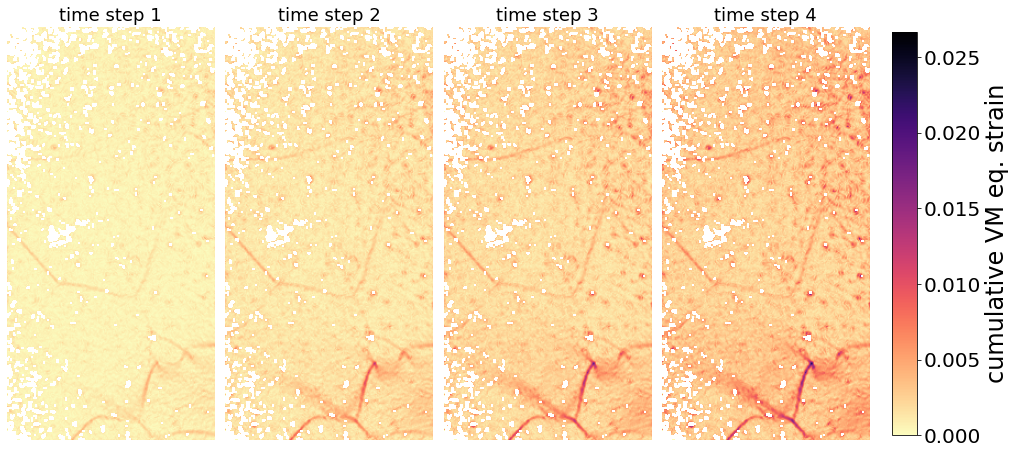

In [8]:
# initialize a 1x4 figure
fig3, axes = plt.subplots(ncols=4, sharey=True, figsize=(14, 8), constrained_layout=True)

for index, ax in enumerate(axes.flat):
    ax.set_axis_off()
    im = ax.imshow(data.fstrain[:, :, index], vmax=np.nanmax(data.fstrain[:, :, 4]), cmap='magma_r')
    ax.set_title(f'time step {index + 1}', fontsize=18)

# add color bar
cbar = fig3.colorbar(im, ax=axes, shrink=0.7, location='right')
cbar.set_label('cumulative VM eq. strain', fontsize=24)
cbar.ax.tick_params(labelsize=20)

## Normalize the equivalent strain using the average strain

Equivalent strain normalization serves to illustrate which parts of the region of interest develop strain above and below the average strain. The first thing to do is to check what type of distribution presents the variable in question in order to choose the best suited average. Generally speaking, if normal-like we should use the arithmetic mean but if lognormal-like we should opt for the median or the geometric mean instead.

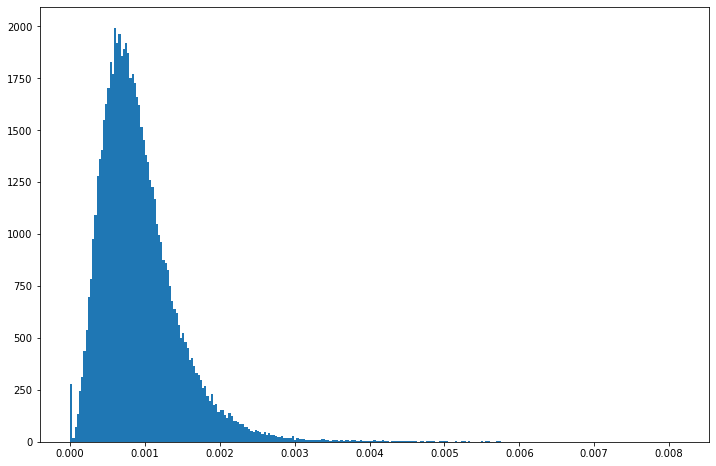

In [9]:
# plot an histogram of one of the slices of the equivalent strain (_ = ... hides the output)
_ = plt.hist(data.eq_strain[:, :, 1].flatten(), bins='auto')  # 'auto' uses the Freedman-Diaconis rule to estimate the number of bins

The distribution is clearly asymmetric and lognormal-like, although there are some zero values (likely DIC correlation artifacts or deformations too small to be detected by the DIC) that break the lognormal-like assumption. Due to this I will use the median over the geometric mean as the latter does not allow zero values. More specifically I will use the ``nanmedian`` method to ignore the ``nan`` values in the dataset.

To estimate the normalized equivalent strain maintaining for every time step we have to normalize over the ``axis=2`` (y, x, time steps), then we need take all the values of axis 0 and 1 and estimate the median along axis 2 by dividing the whole array using numpy broadcasting rules*.

> **Note**: _When operating on two arrays, NumPy compares their shapes element-wise. It starts with the trailing dimensions and works its way forward. Two dimensions are compatible when (i) they are equal, or (ii) one of them is 1._

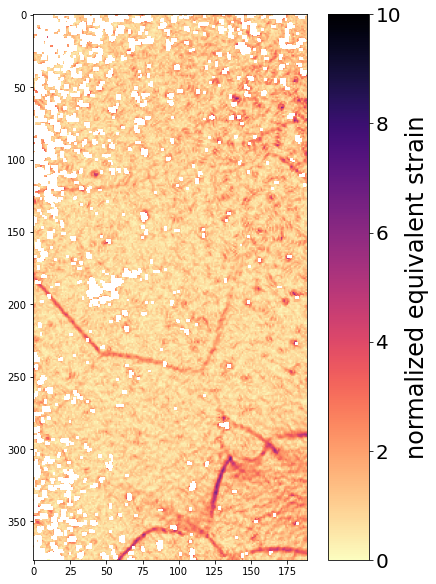

In [10]:
# Estimate the normalized equivalent strain using numpy broadcasting (377, 189, 10) / (10,)
data.norm_eqStrain = data.eq_strain / np.nanmedian(data.eq_strain, axis=[0, 1])

# initialize figure
fig4, ax = plt.subplots(constrained_layout=True)

# image (take slice 1 --> [:, :, 0])
im = ax.imshow(data.norm_eqStrain[:, :, 0], vmin=0, vmax=10, cmap='magma_r')

# add color bar
cbar = fig4.colorbar(im, ax=ax)
cbar.set_label('normalized equivalent strain', fontsize=24)
cbar.ax.tick_params(labelsize=20)

In the map above we see that the local incremental deformation is almost up to an order of magnitude larger than the median. To further facilitate the visualisation of the normalized equivalent strain, let's plot the same in a logarithmic color scales so that values below (< 1) and above (> 1) the average strain shown in blue and red respectively.

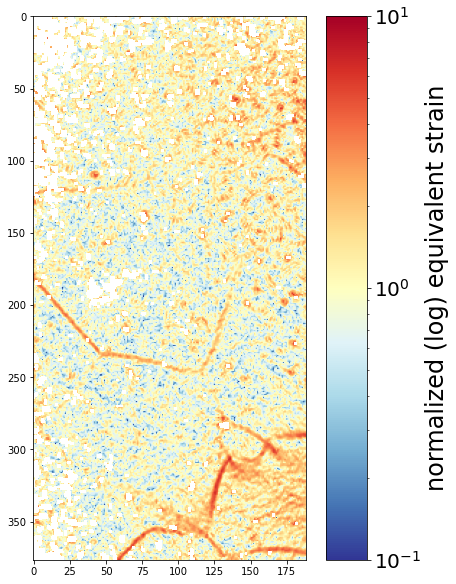

In [11]:
import matplotlib.colors as colors

fig5, ax = plt.subplots(constrained_layout=True)

im = ax.imshow(data.norm_eqStrain[:, :, 0], norm=colors.LogNorm(vmin=1e-1, vmax=10), cmap='RdYlBu_r')

# add color bar
cbar = fig5.colorbar(im, ax=ax)
cbar.set_label('normalized (log) equivalent strain', fontsize=24)
cbar.ax.tick_params(labelsize=20)

Now, let's visualise the whole dataset to see the evolution of strain with time using the normalised equivalent strain. As we are dealing with 10 time steps we will make a figure of 2x5 axes. Note that as alredy indicated the first five and the last five time steps represent different moments in the development of the deformation.

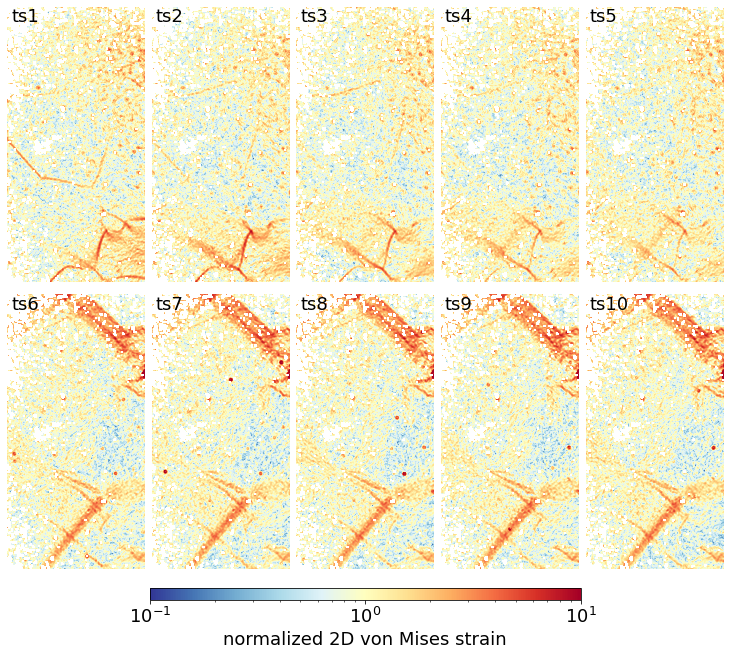

In [12]:
# initialize figure
fig6, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 9), constrained_layout=True)

for index, ax in enumerate(axes.flat):
    ax.set_axis_off()
    im = ax.imshow(data.norm_eqStrain[:, :, index], norm=colors.LogNorm(vmin=1e-1, vmax=10), cmap='RdYlBu_r')
    ax.text(x=5, y=20, s=f'ts{index + 1}', fontsize=18)
    ax.set_aspect('equal')

# add color bar
cbar = fig6.colorbar(im, ax=axes, shrink=0.6, location='bottom')
cbar.set_label('normalized 2D von Mises strain', fontsize=18)
cbar.ax.tick_params(labelsize=18)

Now let's plot the in-plane rotation of the strain so that we observe the shear band kinematics. Since rotations are positive clockwise and negative anticlockwise, we will use a divergent colour map centred on zero so that different colours represent different kinematics.

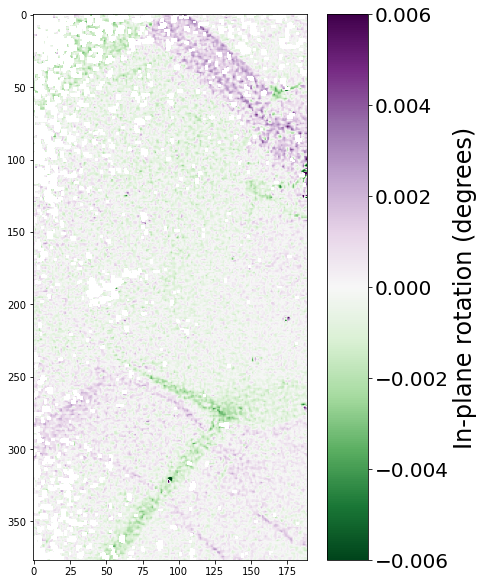

In [13]:
# initialize figure
fig, ax = plt.subplots(constrained_layout=True)

# image (take slice 8 --> [:, :, 7])
im = ax.imshow(data.rotZ[:, :, 8], vmin=-6e-3, vmax=6e-3, cmap='PRGn_r')

# add the color bar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('In-plane rotation (degrees)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

In the above example we set the min and max values of the colormap manually to ± 6e-3. We can automate this by doing the following

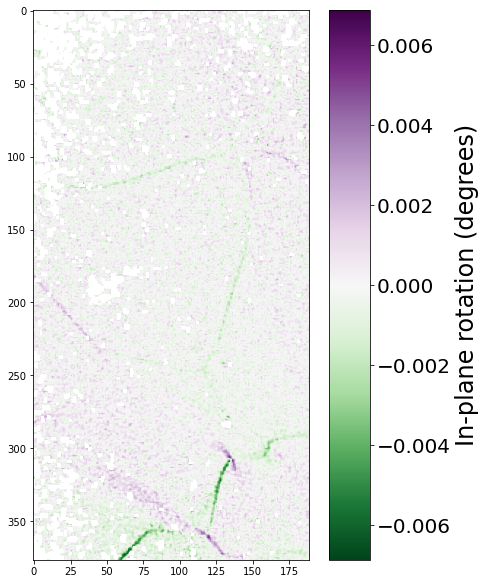

In [14]:
# initialize figure
fig, ax = plt.subplots(constrained_layout=True)

# image
im = ax.imshow(data.rotZ[:, :, 1], vmin=-6e-3, vmax=6e-3, cmap='PRGn_r')

# set colorbar limit based on limit values (this centers the colour map at zero == no rotation)
if np.abs(np.nanmin(data.rotZ[:, :, 1])) >= np.nanmax(data.rotZ[:, :, 1]):
    im.set_clim(np.nanmin(data.rotZ[:, :, 1]), np.abs(np.nanmin(data.rotZ[:, :, 1])))
else:
    im.set_clim(-np.nanmax(data.rotZ[:, :, 1]), np.nanmax(data.rotZ[:, :, 1]))

# add the color bar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('In-plane rotation (degrees)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

## Using convolution (from astropy) to fill and smooth the data



In [15]:
from astropy.convolution import Gaussian2DKernel, Box2DKernel
from astropy.convolution import convolve

# set the kernel. By default the Gaussian2DKernel uses a 9x9 array kernel
kernel = Gaussian2DKernel(x_stddev=1.25)
kernel2 = Box2DKernel(width=3)
astropy_conv = convolve(data.norm_eqStrain[:, :, 0], kernel)
astropy_conv2 = convolve(data.norm_eqStrain[:, :, 0], kernel2)

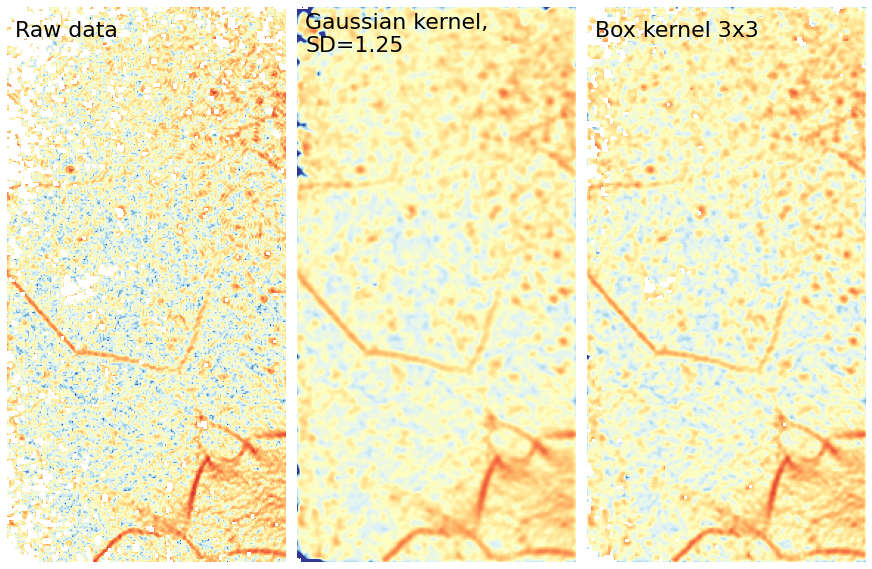

In [16]:
fig7, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, constrained_layout=True)

ax1.imshow(data.norm_eqStrain[:, :, 0], norm=colors.LogNorm(vmin=1e-1, vmax=10), cmap='RdYlBu_r')
ax2.imshow(astropy_conv, norm=colors.LogNorm(vmin=1e-1, vmax=10), cmap='RdYlBu_r')
ax3.imshow(astropy_conv2, norm=colors.LogNorm(vmin=1e-1, vmax=10), cmap='RdYlBu_r')

ax1.text(x=5, y=20, s='Raw data', fontsize=22)
ax2.text(x=5, y=30, s='Gaussian kernel, \nSD=1.25', fontsize=22)
ax3.text(x=5, y=20, s='Box kernel 3x3', fontsize=22)

ax1.set_axis_off()
ax2.set_axis_off()
_ = ax3.set_axis_off()

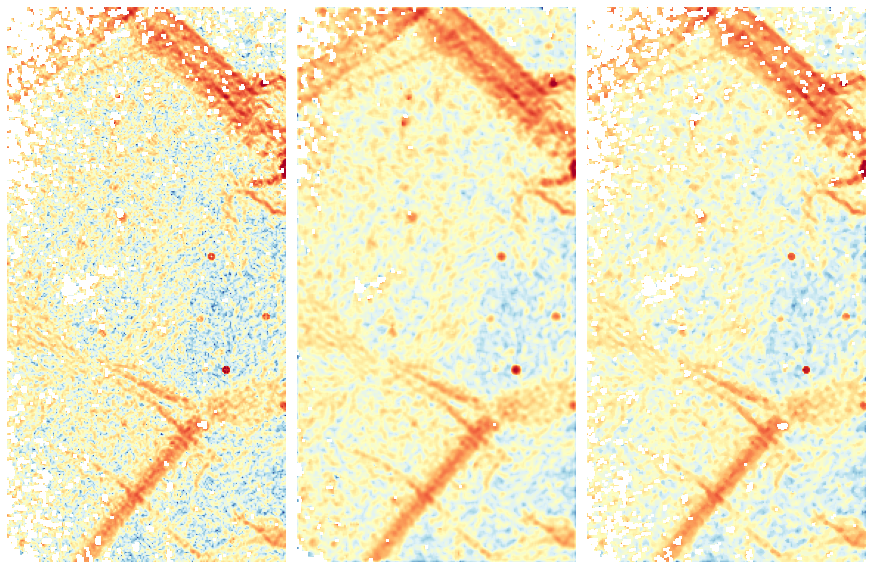

In [17]:
# compare astropy to scipy medfilt
from scipy.signal import medfilt

astropy_conv = convolve(data.norm_eqStrain[:, :, 7], kernel2)
scipy_conv = medfilt(data.norm_eqStrain[:, :, 7], [3, 3])  # use a median filter with a 3x3 kernel

fig8, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, constrained_layout=True)

ax1.imshow(data.norm_eqStrain[:, :, 7], norm=colors.LogNorm(vmin=1e-1, vmax=10), cmap='RdYlBu_r')
ax2.imshow(astropy_conv, norm=colors.LogNorm(vmin=1e-1, vmax=10), cmap='RdYlBu_r')
ax3.imshow(scipy_conv, norm=colors.LogNorm(vmin=1e-1, vmax=10), cmap='RdYlBu_r')

ax1.set_axis_off()
ax2.set_axis_off()
_ = ax3.set_axis_off()

In [18]:
import sys
import matplotlib as mpl

print('Notebook tested using:')
print('Python', sys.version)
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)

Notebook tested using:
Python 3.9.5 (default, May 18 2021, 14:42:02) [MSC v.1916 64 bit (AMD64)]
Numpy 1.20.2
Pandas 1.2.4
Matplotlib 3.3.4
